# Arboles de decisión

Esta notebook presenta un ejemplo de uso de árboles de decisión utilizando datos meteorológicos de la estación meteorológica en Ezeiza. En particular buscaremos predecir la ocurrencia de **niebla** definida como una disminución de la visibilidad menor o igual a 1 km. 

## Datos

Los datos correspondientes a la estación Ezeiza corresponden a mediciones horarias desde 1979 de:

| Nombre      | Descripción |
| :-          | :-|
|`dates`      | fecha y hora (ymdhm)|
|`temperature`| temperatura en grados centígrados|
|`dewpoint`   | temperatura de punto de rocío en grados centígrados|
|`windspeed`  | velocidad del viento en km/h|
|`winddir`    | dirección del viento en grados (99.0 identifica la calma)|
|`vis`        | visibilidad en km|
|`rh`         | humedad relativa entre 0 y 1|
|`pressure`   | presión en hPa|
|`undef`      | valores faltantes|

In [128]:
import SynopDataModule as SDM # para la lectura de los datos
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.tree import export_graphviz
from graphviz import Source

# para guardar figuras de los arboles 
IMAGES_PATH = Path() / "images" / "decision_trees"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

`data` es un diccionario que incluye 'dates', 'temperature', 'dewpoint', 'windspeed', 'winddir', 'vis', 'rh', 'pressure', 'undef' (`data.keys()`). 

In [122]:
data = SDM.read_raw_data("../Datos/EXP_133453_HORA.txt")

## Classificación

Generamos la variable target o predictando `niebla` dicotomisando la variable `vis`. Definimos niebla como visbilidad igual o menor a 1 km (`vis <= 1`), por lo tanto en nuestra variable `niebla = 1` corresponderá a un evento de niebla, `niebla = 0` será un evento de no niebla.

Al calcular el porcentaje de casos de niebla respecto del total de datos, vemos que los casos niebla/no niebla están muy desvalanceados. Esto puede generar un sesgo en nuestro modelo hacia los casos de no niebla, subestimando los casos de niebla. 

In [123]:
data["niebla"] = (data["vis"] <= 1.).astype(int)

porcentaje_niebla = np.mean(data["niebla"])
print("Porcentaje de casos de niebla:", porcentaje_niebla*100)

Porcentaje de casos de niebla: 5.908297083020626


## Predictores

Si bien se pueden hacer pruebas para definir la mejor combinación de predictores, inicialmente usaremos lo que sabemos sobre nieblas para definir los predictores. En este caso serán:

* velocidad del viento -- poco o cero viento debería ayudar a la generación de niebla
* humedad relativa -- valores cercanos a 100% de humedad deberían estar asociados a niebla 
* hora del día -- de acuerdo a la climatología, los eventos de niebla se dan a la noche y madrugada

In [124]:
# extraemos la hora del día de `dates`
data["hours"] = np.array([x.hour for x in data["dates"]])

predictores = ["windspeed", "rh", "hours"]

# los datos deben estar en arrays
x_values = np.array([data[x] for x in predictores], dtype=object).transpose()
y_values = data["niebla"]

# entrenamos el arbol
# max_depth = 3 para liminar el crecimiento del árbol (y poder visualizarlo!) 
# random_state = 42 para obtener siempre el mismo árbol
tree_niebla = DecisionTreeClassifier(max_depth = 3, random_state = 42)
tree_niebla.fit(x_values, y_values)


DecisionTreeClassifier(max_depth=3, random_state=42)

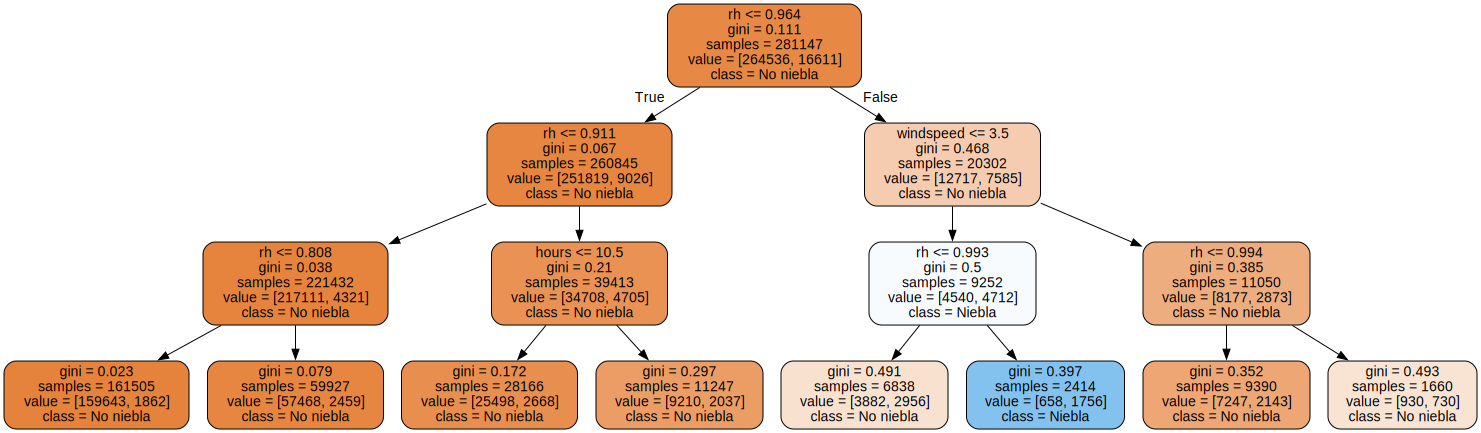

In [125]:
# también tree.plot_tree(tree_niebla)

export_graphviz(
        tree_niebla,
        out_file = str(IMAGES_PATH / "iris_tree.dot"),  
        feature_names = predictores,
        class_names = ["No niebla", "Niebla"],
        rounded = True,
        filled = True
)

Source.from_file(IMAGES_PATH / "iris_tree.dot")

## Predicciones

Con este primer árbol podemos hacer predicciones. Por ejemplo, si tenemos la velocidad del viento (1 km/h) y humedad relativa (99.9%) pronosticada para las 6 AM podemos intentar predecir la ocurrencia de niebla con nuestro árbol.

Recordemos que 1 = niebla

In [132]:
tree_niebla.predict([[1., 0.999, 6]])

array([1])

Sin embargo, es importante evaluar la precisión del modelo. Una posibilidad es comparar los valores predichos por el árbol con los valores observados. Podemos utilizar una tabla o matriz de contingencia para calcular las frecuencias relativas de los eventos.

![](https://www.westgard.com/images/stories/2020-contingency-table-spanish-1.jpg)

* verdaderos negativos: no se pronosticó niebla y no ocurrió
* falsos negativos o sorpresas: no se pronosticó niebla pero se observó
* verdaderos positivos: se pronosticó niebla y ocurrió
* falsos positivos o alarma: se pronosticó niebla pero no se observó

In [141]:
niebla_pred = tree_niebla.predict(pred_values)

pd.crosstab(niebla_pred, y_values, rownames = ["Pred"], colnames = ["Obs"], margins = True)
# expresado como porcentaje respecto del total
pd.crosstab(niebla_pred, y_values, rownames = ["Pred"], colnames = ["Obs"], normalize = "all")

Obs,0,1
Pred,,
0,0.938577,0.052837
1,0.002340,0.006246


Cómo era de esperarse el modelo está muy sesgado hacia los eventos de no niebla (casi 94% de los casos) con un 5% de sospresas (subestima la ocurrencia de niebla). 

Otra manera de evaluar nuestro modelo es calculando el score o precisión media:

In [142]:
tree_niebla.score(x_values, y_values)

0.9448224594251405

## Balancenado clases

Una manera de resolver el desbalance entre los eventos de no niebla y niebla es asignando pesos a cada clase (`niebla = 1`, `no niebla = 0`). Estos pesos se pueden asignar manualmente o automaticamente usando `class_weight = "balanced"`. En este último caso el peso de una clase es inversamente proporcional a su frecuencia:

`n_samples / (n_classes * np.bincount(y))`

In [146]:
tree_niebla_bal = DecisionTreeClassifier(max_depth = 3, random_state = 42, class_weight = "balanced")
tree_niebla_bal.fit(x_values, y_values)

pd.crosstab(tree_niebla_bal.predict(pred_values), y_values, 
            rownames = ["Pred"], colnames = ["Obs"], normalize = "all")

Obs,0,1
Pred,,
0,0.750661,0.013890
1,0.190256,0.045193


En este caso, si bien el porcentaje de falsos positivos (alarmas) aumenta de 0.2% a 19% también aumentan el porcentaje de aciertos de ocurrencia de niebla de 0.6% a 4.5% y disminuyen las sorpresas. El aumento de las alarmas podría interpretarse como perjudicial pero cuando se trata de pronosticar eventos asociados a un impacto muy grade, tal vez sea preferible a tener muchas sorpresas. 